## Motor de recomendación con Filtrado Colaborativo

![fruta.PNG](https://i2.wp.com/www.aprendemachinelearning.com/wp-content/uploads/2019/08/matriz_recomendacion.png?w=560&ssl=1)


### Primero, cargamos las librerías y visualizamos las bases de datos a utilizar:

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import sklearn

In [2]:
df_users = pd.read_csv("users.csv")
df_repos = pd.read_csv("repos.csv")
df_ratings = pd.read_csv("ratings.csv")
print(df_users.head())
print(df_repos.head())
print(df_ratings.head())

   userId     username                  name
0       1     iris9112  Isabel Ruiz Buriticá
1       2  dianaclarke                 Diana
2       3  nateprewitt          Nate Prewitt
3       4       oldani       Ordanis Sanchez
4       5   waflessnet            waflessnet
   repoId                              title  \
0       1                airbnb / javascript   
1       2  kamranahmedse / developer-roadmap   
2       3                 microsoft / vscode   
3       4                   torvalds / linux   
4       5              ytdl-org / youtube-dl   

                                          categories    stars  
0                                          completar      NaN  
1        Roadmap to becoming a web developer in 2019  85800.0  
2                                 Visual Studio Code  80855.0  
3                           Linux kernel source tree  78761.0  
4  Command-line program to download videos from Y...  53909.0  
   userId  repoId  rating
0       1       1       2
1    

In [3]:
n_users = df_ratings.userId.unique().shape[0]
n_items = df_ratings.repoId.unique().shape[0]
print (str(n_users) + ' usuarios ')
print (str(n_items) + ' productos')

30 users
167 items


### Vemos que es un dataset reducido: contamos con 30 usuarios y 167 repositorios valorados.



(array([94., 62., 66., 28., 40., 12., 14.,  8.]),
 array([1.   , 1.875, 2.75 , 3.625, 4.5  , 5.375, 6.25 , 7.125, 8.   ]),
 <a list of 8 Patch objects>)

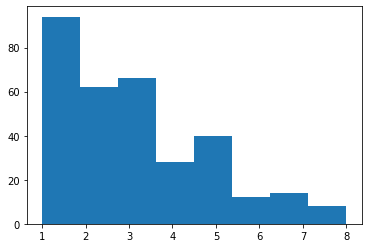

In [4]:
plt.hist(df_ratings.rating,bins=8)

### Tenemos más de 80 valoraciones con una puntuación de 1 y unas 40 con puntuación en 5. Veamos las cantidades exactas:

In [5]:
df_ratings.groupby(["rating"])["userId"].count()

rating
1    94
2    62
3    66
4    28
5    40
6    12
7    14
8     8
Name: userId, dtype: int64

(array([94., 31., 22.,  7.,  8.,  2.,  2.,  1.]),
 array([1.   , 1.875, 2.75 , 3.625, 4.5  , 5.375, 6.25 , 7.125, 8.   ]),
 <a list of 8 Patch objects>)

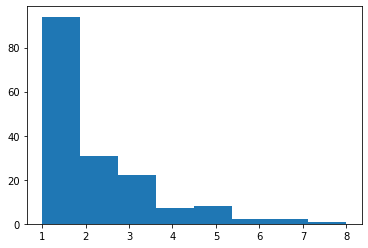

In [6]:
plt.hist(df_ratings.groupby(["repoId"])["repoId"].count(),bins=8)

### Aquí vemos la cantidad de repositorios y cuantos usuarios “los tienen”. Ahora crearemos la matriz en la que cruzamos todos los usuarios con todos los repositorios:

In [7]:
df_matrix = pd.pivot_table(df_ratings, values='rating', index='userId', columns='repoId').fillna(0)
df_matrix

repoId,1,2,3,4,5,6,7,8,9,10,...,158,159,160,161,162,163,164,165,166,167
userId,,,,,,,,,,,,,,,,,,,,,
1,2.0,3.0,4.0,5.0,3.0,1.0,5.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Vemos que rellenamos los “huecos” de la matriz con ceros. Y esos ceros serán los que deberemos reemplazar con las recomendaciones. Veamos el porcentaje de sparcity que tenemos:


In [8]:
ratings = df_matrix.values
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 6.43%


### Esto serán muchos “ceros” que rellenar (predecir). Separamos en train y test para -más adelante- poder medir la calidad de nuestras recomendaciones.


In [9]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2, random_state=42)
print(ratings_train.shape)
print(ratings_test.shape)

(24, 167)
(6, 167)


### Ahora calculamos en una nueva matriz la similitud entre usuarios:

In [10]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings)
print(sim_matrix.shape)

(30, 30)


### Cuanto más cercano a 1, mayor similitud entre esos usuarios.

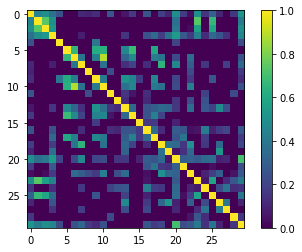

In [11]:
plt.imshow(sim_matrix);
plt.colorbar()
plt.show()

In [12]:
#separar las filas y columnas de train y test
sim_matrix_train = sim_matrix[0:24,0:24]
sim_matrix_test = sim_matrix[24:30,24:30]

users_predictions = sim_matrix_train.dot(ratings_train) / np.array([np.abs(sim_matrix_train).sum(axis=1)]).T

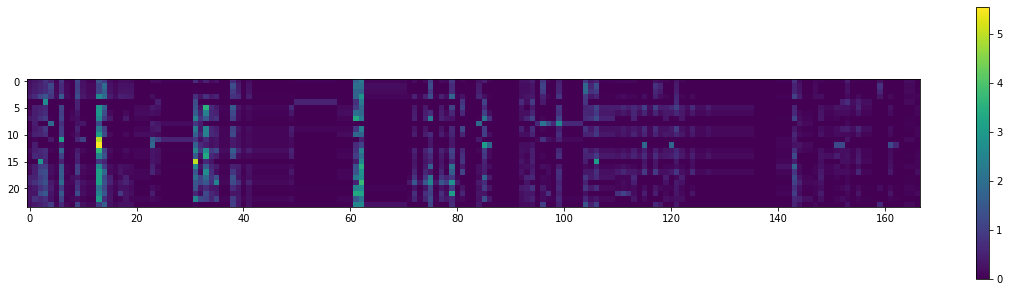

In [13]:
plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(users_predictions);
plt.colorbar()
plt.show()

### Vemos pocas recomendaciones que logren puntuar alto. La mayoría estará entre 1 y 2 puntos. Esto tiene que ver con nuestro dataset pequeño.

In [14]:
USUARIO_EJEMPLO = 'jbagnato'
data = df_users[df_users['username'] == USUARIO_EJEMPLO]
usuario_ver = data.iloc[0]['userId'] - 1 # resta 1 para obtener el index de pandas.

user0=users_predictions.argsort()[usuario_ver]

# Veamos los tres recomendados con mayor puntaje en la predic para este usuario
for i, aRepo in enumerate(user0[-3:]):
    selRepo = df_repos[df_repos['repoId']==(aRepo+1)]
    print(selRepo['title'] , 'puntaje:', users_predictions[usuario_ver][aRepo])

23    ansible / ansible
Name: title, dtype: object puntaje: 1.6300984296308052
6    pallets / flask
Name: title, dtype: object puntaje: 3.124047243895186
13    python / cpython
Name: title, dtype: object puntaje: 4.998475590232298
